In [1]:
import argparse
import json
import os
import pathlib
import zipfile
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import requests
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm, trange

imagenet_path = '/home/vista/Datasets/ILSVRC/Data/CLS-LOC'
#imagenet_path = '/home/chaimb/ILSVRC/Data/CLS-LOC'
objectnet_path = '/home/chaimb/objectnet-1.0'


In [2]:
def download_file(url, filename=False, verbose=False):
    """
    Download file with progressbar

    Usage:
        download_file('http://web4host.net/5MB.zip')
    """
    if not filename:
        local_filename = os.path.join(".", url.split('/')[-1])
    else:
        local_filename = filename

    response = requests.get(url, stream=True)

    with open(filename, "wb") as handle:
        for data in tqdm(response.iter_content()):
            handle.write(data)
    return


In [3]:
# test
IMAGE_SHAPE = (224, 224)
train_dir = pathlib.Path(os.path.join(imagenet_path, 'train'))
val_dir = pathlib.Path(os.path.join(imagenet_path, 'val'))
object_dir = pathlib.Path(os.path.join(objectnet_path, 'images'))

In [4]:
assert val_dir.exists()
assert train_dir.exists()

In [5]:
CLASS_NAMES = np.array([item.name for item in train_dir.glob('*') if item.name != "LICENSE.txt"])
CLASS_NAMES_OBJ = np.array([item.name for item in object_dir.glob('*') if item.name != "LICENSE.txt"])

In [6]:

map_url = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
response = json.loads(requests.get(map_url).text)
name_map = {}
name_to_num = {}
for r in response:
    name_map[response[r][0]] = response[r][1]
    name_to_num[response[r][1]] = response[r][0]


In [7]:

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n])
        plt.title(name_map[CLASS_NAMES[label_batch[n] == 1][0].title().lower()])
        plt.axis('off')


In [8]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES


def get_label_objectnet(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == CLASS_NAMES_OBJ


def decode_img(img, IMG_HEIGHT=224, IMG_WIDTH=224, pm1=False):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # Use `convert_image_dtype` to convert to floats in the [0,1] range.
    if pm1:
        img = tf.cast(img, tf.float32) / (255. / 2.) - 1
    else:
        img = tf.image.convert_image_dtype(img, tf.float32)
    if IMG_HEIGHT == 256:
        SIZE = 292
    else:
        SIZE = 256
    # resize the image to the desired size.
    return tf.image.central_crop(tf.image.resize(img, [SIZE, SIZE]), 0.875)


def process_path(file_path, bbg=False, label_function=get_label):
    label = label_function(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    if bbg:
        img = decode_img(img, 256, 256, True)
    else:
        img = decode_img(img)
    return img, label


def prepare_for_eval(ds, batch_size):
    ds = ds.batch(batch_size)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=640)

    return ds


In [9]:

def get_datasets(bbg=False):
    BATCH_SIZE = 32
    process = partial(process_path, bbg=bbg, label_function=get_label)
    process_obj = partial(process_path, bbg=bbg, label_function=get_label_objectnet)

    list_ds = tf.data.Dataset.list_files(str(train_dir / '*/*'), shuffle=False)
    # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
    labeled_ds = list_ds.map(process, num_parallel_calls=8)

    train_ds = prepare_for_eval(labeled_ds, BATCH_SIZE)

    list_val_ds = tf.data.Dataset.list_files(str(val_dir / '*/*'), shuffle=False)
    # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
    labeled_val_ds = list_val_ds.map(process, num_parallel_calls=8)

    val_ds = prepare_for_eval(labeled_val_ds, BATCH_SIZE)
    return train_ds, val_ds


In [10]:
def get_resnet50x4_simclr():
    resnet50x4_url = "https://storage.cloud.google.com/simclr-gcs/checkpoints/ResNet50_1x.zip"

    os.makedirs('./checkpoints', exist_ok=True)

    resnet50x4_path = './checkpoints/checkpoints_ResNet50_4x'
    # download_file(resnet50_url,resnet50_path+'.zip')
    with zipfile.ZipFile(resnet50x4_path + '.zip', "r") as zip_ref:
        zip_ref.extractall('./checkpoints')

    resnet50x4_path = './checkpoints/ResNet50_4x'
    resnet50x4 = tf.keras.Sequential([
        hub.KerasLayer(os.path.join(resnet50x4_path, 'hub'))
    ])

    return resnet50x4


In [11]:
def get_resnet50_simclr():
    resnet50_url = "https://storage.cloud.google.com/simclr-gcs/checkpoints/ResNet50_1x.zip"

    os.makedirs('./checkpoints', exist_ok=True)

    resnet50_path = './checkpoints/ResNet50_1x'
    # download_file(resnet50_url,resnet50_path+'.zip')
    with zipfile.ZipFile(resnet50_path + '.zip', "r") as zip_ref:
        zip_ref.extractall('./checkpoints')

    resnet50 = tf.keras.Sequential([
        hub.KerasLayer(os.path.join(resnet50_path, 'hub'))
    ])

    return resnet50


In [12]:
def get_resnet152x3_simclrv2():
    module_path = 'gs://simclr-checkpoints/simclrv2/pretrained/r152_3x_sk1/hub/'  # r152_3x_sk1
    resnet152x3 = tf.keras.Sequential([
        hub.KerasLayer(module_path)
    ])
    return resnet152x3


def get_resnet50_simclrv2():
    module_path = 'gs://simclr-checkpoints/simclrv2/pretrained/r50_1x_sk0/hub/'  # r152_3x_sk1
    resnet152x3 = tf.keras.Sequential([
        hub.KerasLayer(module_path)
    ])
    return resnet152x3


def get_resnet152_simclrv2():
    module_path = 'gs://simclr-checkpoints/simclrv2/pretrained/r152_1x_sk1/hub/'  # r152_3x_sk1
    resnet152x3 = tf.keras.Sequential([
        hub.KerasLayer(module_path)
    ])
    return resnet152x3


In [13]:
def get_revnet50x4_bigbigan():
    module_path = 'https://tfhub.dev/deepmind/bigbigan-revnet50x4/1'  # RevNet-50 x4
    revnet50x4 = tf.keras.Sequential([
        hub.KerasLayer(module_path, signature='encode')
    ])

    return revnet50x4


def get_resnet50_bigbigan():
    module_path = 'https://tfhub.dev/deepmind/bigbigan-resnet50/1'  # ResNet-50
    resnet50 = tf.keras.Sequential([
        hub.KerasLayer(module_path, signature='encode')
    ])

    return resnet50


In [14]:
models = ['resnet50_simclr', 'resnet50x4_simclr', 'revnet50x4_bigbigan', 'resnet50_simclr2', 'resnet152_simclr2',
          'resnet152x3_simclr2']


def get_model(model='resnet50_simclr'):
    if model == 'resnet50_simclr':
        return get_resnet50_simclr()
    elif model == 'resnet50x4_simclr':
        return get_resnet50x4_simclr()
    elif model == 'revnet50x4_bigbigan':
        return get_revnet50x4_bigbigan()
    elif model == 'resnet50_bigbigan':
        return get_resnet50_bigbigan()
    elif model == 'resnet50_simclr2':
        return get_resnet50_simclrv2()
    elif model == 'resnet152_simclr2':
        return get_resnet152_simclrv2()
    elif model == 'resnet152x3_simclr2':
        return get_resnet152x3_simclrv2()
    else:
        raise ValueError('Wrong model')


In [15]:
def eval(model, ds):
    dit = iter(ds)
    reses = []
    labs = []
    num_elements = tf.data.experimental.cardinality(ds).numpy()
    for ind in trange(num_elements):
        x, y = next(dit)
        result = model.predict_on_batch(x)  # , training=False
        reses.append(result)
        labs.append(y)
    rss = np.concatenate(reses, axis=0)
    lbs = np.concatenate(labs, axis=0)
    return rss, lbs


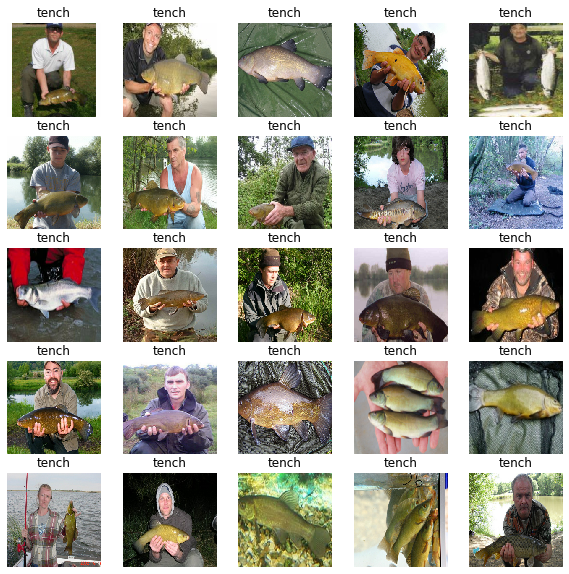

In [16]:
train_ds, val_ds = get_datasets(bbg=False)
image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [17]:
list_ds = tf.data.Dataset.list_files(str(val_dir / '*/*'), shuffle=False)

In [18]:
next(iter(list_ds)).numpy()

b'/home/vista/Datasets/ILSVRC/Data/CLS-LOC/val/n01440764/ILSVRC2012_val_00000293.JPEG'

In [19]:
file_list = np.array([x.numpy() for x in iter(list_ds)])

In [20]:
file_list[np.array([0,12,17])]

array([b'/home/vista/Datasets/ILSVRC/Data/CLS-LOC/val/n01440764/ILSVRC2012_val_00000293.JPEG',
       b'/home/vista/Datasets/ILSVRC/Data/CLS-LOC/val/n01440764/ILSVRC2012_val_00011993.JPEG',
       b'/home/vista/Datasets/ILSVRC/Data/CLS-LOC/val/n01440764/ILSVRC2012_val_00017699.JPEG'],
      dtype='|S83')

In [21]:
num_elements = tf.data.experimental.cardinality(train_ds).numpy()
print(num_elements)
num_elements = tf.data.experimental.cardinality(val_ds).numpy()
print(num_elements)


40037
1563


In [22]:
from PIL import Image

def join_images(*rows, bg_color=(0, 0, 0, 0), alignment=(0.5, 0.5)):
    rows = [
        [Image.fromarray((image*255).astype(np.uint8)).convert('RGBA') for image in row]
        for row
        in rows
    ]

    heights = [
        max(image.height for image in row)
        for row
        in rows
    ]

    widths = [
        max(image.width for image in column)
        for column
        in zip(*rows)
    ]

    tmp = Image.new(
        'RGBA',
        size=(sum(widths), sum(heights)),
        color=bg_color
    )

    for i, row in enumerate(rows):
        for j, image in enumerate(row):
            y = sum(heights[:i]) + int((heights[i] - image.height) * alignment[1])
            x = sum(widths[:j]) + int((widths[j] - image.width) * alignment[0])
            tmp.paste(image, (x, y))

    return tmp

def resize(infile, size):
    size = (size,size) if isinstance(size,int) else size
    outfile = os.path.splitext(infile)[0] + str(size[0])
    if infile != outfile:
        im = Image.open(infile)
        im.thumbnail(size, Image.ANTIALIAS)
        im.save(outfile, "png")

In [23]:
def show_images(dr, idx, filename='images.pdf'):
    list_ds = tf.data.Dataset.list_files(str(dr / '*/*'), shuffle=False)
    file_list = np.array([x.numpy() for x in iter(list_ds)])
    files = file_list[np.array([idx])].squeeze()
    images = []
    for f in files:
        im, _ = process_path(f, bbg=False, label_function=get_label)
        images.append(im.numpy())
        
    im = images[0]
    #print((im.numpy()*255).astype(int))
    #print(Image.fromarray((im.numpy()*255).astype(int)))
    side = int(np.ceil(np.sqrt(len(images))))
    while len(images)<side**2:
        images.append(np.ones_like(images[0]))
    images_sq = []
    for i in range(0,len(images),side):
        images_sq.append(images[i:i+side])
    tmp = join_images(*images_sq, bg_color=(0, 0, 0, 0), alignment=(0.5, 0.5))
    tmp.save('cluster.png')
    resize('cluster.png', 4096)
    resize('cluster.png', 2048)
    resize('cluster.png', 1024)
    return
    

In [24]:
show_images(val_dir, np.random.randint(50000, size=(256,)))

In [25]:
def eval_and_save(model='resnet50_simclr'):
    mdl = get_model(model)
    train_embs, train_labs = eval(mdl, train_ds)
    val_embs, val_labs = eval(mdl, val_ds)
    obj_embs, obj_labs = eval(mdl, obj_ds)
    os.makedirs('./results', exist_ok=True)
    np.savez(os.path.join('./results', model + '.npz'), train_embs=train_embs, train_labs=train_labs, val_embs=val_embs,
             val_labs=val_labs, obj_embs=obj_embs, obj_labs=obj_labs)


# eval_and_save(model)